# Demo: Applying the Kalman Filter to Estimate the Position of a Damped Harmonic Oscillator

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import time

# this makes sure the images don't come out looking muddy on 
# retina displays (which your computer probably uses)
%config InlineBackend.figure_format='retina'

# Finally, print nice Latex labels for figures. 
# Comment these out if you don't want to wait for the tex to compile, or don't
# want to bother get tex working. 
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# also, we should manually set the dpi for figures so they look good
# if saving figs, you should do so at a much higher dpi!
dpi = 300

# finally, fix the seed for reproducibility. Comment this if you want to mess around a bit. 
np.random.seed(32)

In this demo we use the amazing **Kalman filter** to obtain a good state estimator for a simple mechanical system, namely a damped linear oscillator with a bit of noise. 

Notational remark: throughout this discussion, an overheard caret denotes the average. 

## Recommended Reading

- Balakrishnan, *Kalman Filtering Theory*. Optimization Software Inc., 1987. 
- Pei et al, "An Elementary Introduction to Kalman Filtering". Preprint, 2019. Available at https://arxiv.org/pdf/1710.04055.pdf.
- Stengel, *Optimal Control and Estimation*. Dover, 1994. 

## Problem Setup

We consider a noisy, unforced damped linear oscillator, with only position being observable. Our state vector is then $\mathbf{x}(t) = \left[x(t), \ \dot{x}(t)\right]^{\mathrm{T}}$ (where $x(t)$ is the oscillator's position), and our system's output is denoted $y(t) \ (= x(t))$. If $\omega_0>0$ is the natural frequency, $\zeta \in (0,1)$ is the damping ratio, and $w(t)\sim \mathcal{N}(0,\sigma^2)$ denotes a mean-zero noise term with variance $\sigma^2$, then the state-space form of the dynamics reads

\begin{equation*}
    \left\{
        \begin{aligned}
            \dot{\mathbf{x}} &= \begin{bmatrix} 0 & 1
            \\
             -\omega_0^2 & -2\zeta\omega_0
             \end{bmatrix}\mathbf{x} + \begin{bmatrix} 0 \\ w(t)\end{bmatrix}
            %+ \begin{bmatrix} 0 \\ b \end{bmatrix} u # TODO: add flexibility for a controlling input!
             \\ \\ 
             y &= \left(1,0\right)\mathbf{x}.
        \end{aligned}
    \right.
    \end{equation*}

If $w=0$ (equivalently, if we take the average over all possible realizations of $x(t)$), the exact solution for $x(t)$ is 

$$
\widehat{x}(t) = e^{-\zeta \omega_0 t}\left(a_1\cos\left(\omega_0\sqrt{1-\zeta^2} \ t\right)+ a_2\sin\left(\omega_0\sqrt{1-\zeta^2} \ t\right) \right)
$$

where $a_1 = x(0)$ and $a_2 = \dot{x}(0)/\left(\omega_0\sqrt{1-\zeta^2}\right)$. If we sample $x(t)$ at discrete times $t_{n}=n\Delta t$, then 

$$
\widehat{x}_n \doteq \widehat{x}\left(n\Delta t\right) = e^{-\zeta \omega_0 n\Delta t}\left(a_1\cos\left(\omega_0\sqrt{1-\zeta^2} \ n\Delta t\right)+ a_2\sin\left(\omega_0\sqrt{1-\zeta^2} \ n\Delta t\right) \right). 
$$


Our goal is to see how well we can reproduce the "ground truth" sequence $\widehat{x}_n$ using only 

1) simulated discrete-time data $z_n$ and

3) a deterministic, data-agnostic difference equation modelling the zero-noise dynamics.

The **Kalman filter** allows us to achieve this goal. 

Let's code up the basic objects we've introduced so far. First, we set up the parameters for the problem. 

In [2]:
# Physical params
w0 = 6.
zeta = 0.1
w1 = w0*np.sqrt(1-zeta**2)

# ground truth initial state
x0 = 1.
v0 = 0. 
ic = np.array([[x0], [v0]])

# amplitudes
a1 = x0
a2 = v0/w1

# time interval we consider is [0,T]
T = 4.

# choose sample spacing dt
dt = 1e-1

# get total num of samples
N = int(T/dt)

Now, we can easily compute the ground truth $\widehat{x}_{n}$. 

In [3]:
t = dt*np.arange(0,N+1)
x_true = np.exp(-w0*zeta*t)*(a1*np.cos(w1*t) + a2*np.sin(w1*t))

To simulate the measurement data $z_n$, we simply add a random perturbation to the ground truth. Note how the standard deviation of this perturbation is $\sigma=\texttt{scale}$ (the same "sigma" appearing in $w$ above): this will come in handy later when we need to talk about measurement error.  

In [4]:
scale = 0.05 # this plays the role of the parameter "lowercase{sigma}" introduced earlier. 

obs = x_true + np.random.normal(loc = 0., scale = scale, size= N+1)

# will also need noisy ics for simulations later
vinit_noisy = np.random.normal(loc = 0., scale = scale)

ic_noisy = np.array([[obs[0]],[vinit_noisy]])

Let's plot the noisy measurements versus the ground truth.

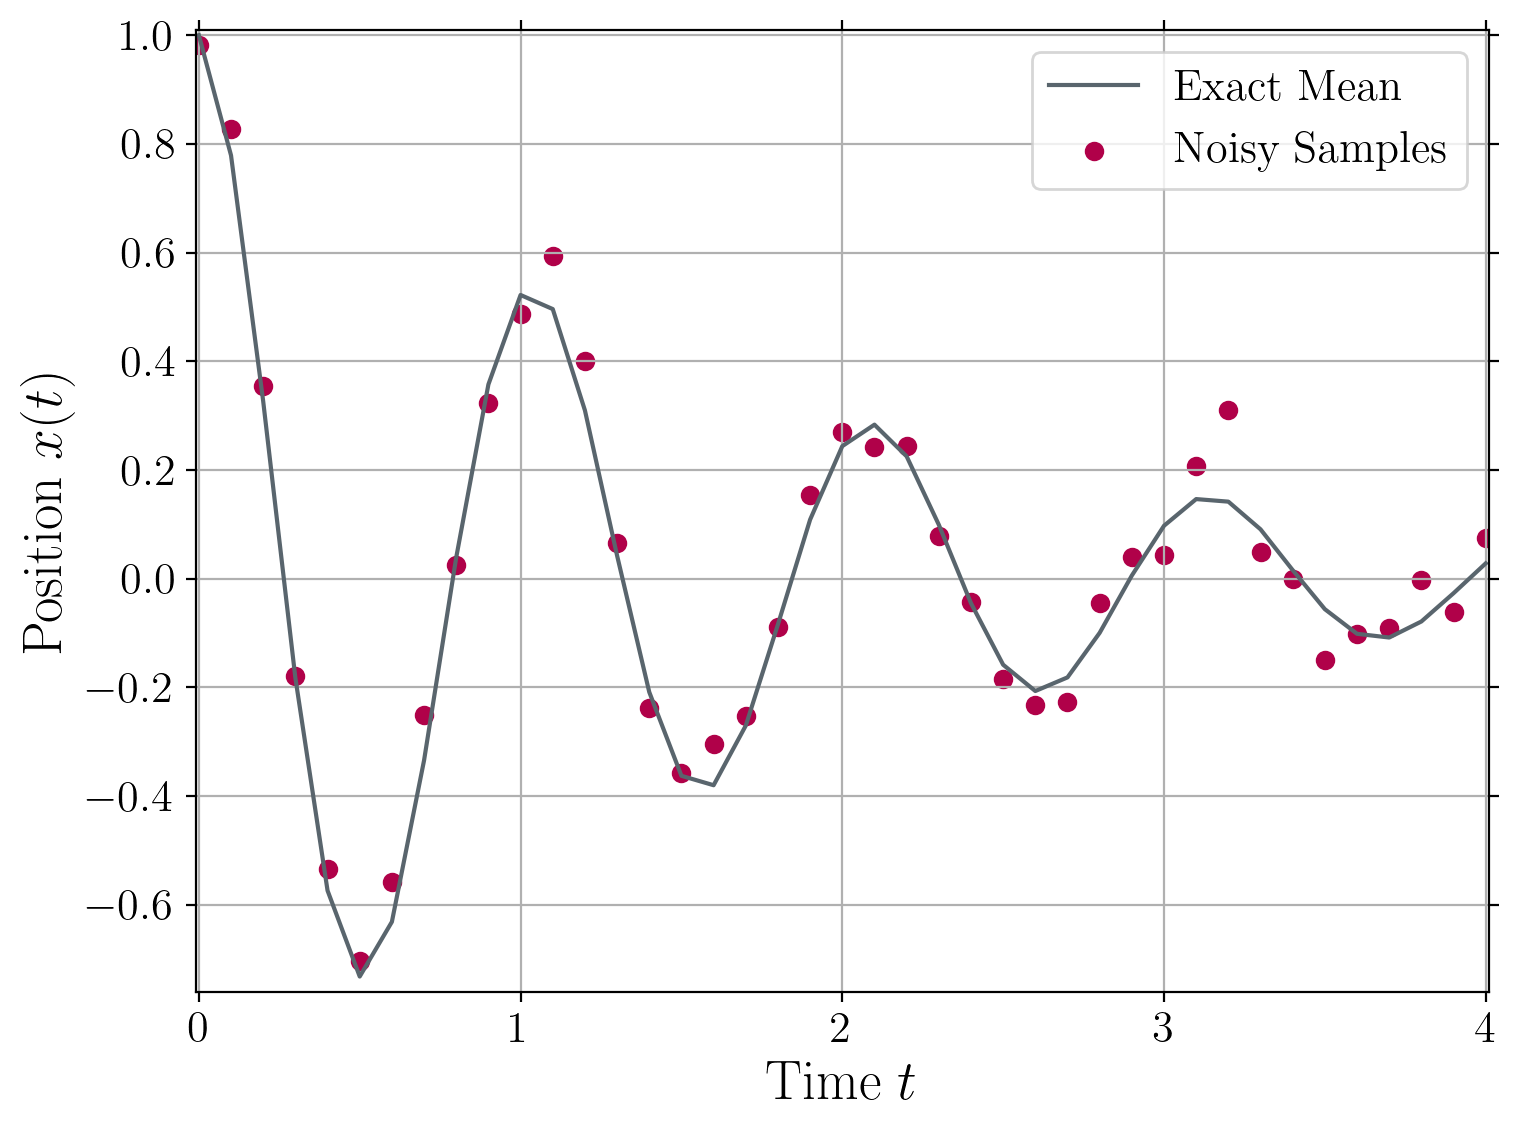

In [5]:
fig, ax =plt.subplots()

plt.frameon = True 
plt.grid(visible=True)

plt.plot(t, x_true, label='Exact Mean', color='xkcd:slate gray', linewidth=1.5)
plt.scatter(t, obs, color='xkcd:raspberry', label='Noisy Samples')

plt.xlabel(r"Time $t$", fontsize=20, color = 'k')
plt.ylabel(r"Position $x(t)$", fontsize=20, color='k')

plt.tick_params(axis='x', which='both', top='off', color = 'k')
plt.xticks(fontsize=16, rotation=0, color = 'k')
plt.tick_params(axis='y', which='both', right='off', color = 'k')
plt.yticks(fontsize=16, rotation=0, color = 'k')
ax.locator_params(axis='y', nbins=12)
ax.locator_params(axis='x', nbins=8)

plt.legend(loc='upper right', fontsize=16)

plt.xlim([-0.01, 4.01])
plt.ylim([-0.76, 1.01])

plt.tight_layout()

fig.set_size_inches(8, 6)  

plt.show()

## Deterministic, Data-Agnostic Discrete-Time Model of the Dynamics

Now that we've got measurements, we need a discrete-time model of the mean dynamics (equivalently, the dynamics with $w=0$). This may be achieved using numerical methods. For simplicity, we'll go with the simple backward Euler method today (though there are much better stable schemes you could try). Note that there are no speed issues arising from backward Euler with this problem: we've got a linear $2\times 2$ system, so we can perform the required linear solve **once** before we start time-stepping. 

For notation clarity, let's define 

$$
 M = \begin{bmatrix} 0 & 1
            \\
             -\omega_0^2 & -2\zeta\omega_0
             \end{bmatrix}.
$$

The backward Euler scheme applied to our system using step size $\delta t$ (I'm not using $\Delta t$ for a reason!) looks like 

$$
\frac{\mathbf{x}\left(t+\delta t\right)-\mathbf{x}(t)}{\delta t} \approx M\mathbf{x}\left(t+\delta t\right).
$$

Re-arranging gives an update rule: 

$$
\mathbf{x}\left(t+\delta t\right) \approx \left(I - \delta t \ M \right)^{-1} \mathbf{x}\left(t\right) = \frac{1}{1+2\omega_0\zeta \delta t + \left(\omega_0 \delta t\right)^2} \begin{bmatrix} 1+2\omega_0 \zeta \delta t & \delta t
            \\
             -\omega_0^2 \delta t & 1
             \end{bmatrix}\mathbf{x}\left(t\right).
$$

Now, to demonstrate the power of the Kalman filter, I want my deterministic model to do an OK but not great job at describing the dynamics. This means I want to take $\delta t$ to be small enough to capture the qualitative features of the dynamics but big enough so that the model fails to achieve a correct amplitude decay, phase offset, *et cetera*. I've experimentally determined that $\delta t=0.01$ achieves this goal: anything larger gives a simulation with far too much damping. But this shouldn't sit well with you: our sample spacing is $\Delta t = 0.1$ as defined above! This means that we have to run $s=10$ steps of backward Euler per each sampling interval! Accordingly, if we define 

$$
A = \left(\left(I - \delta t \ M \right)^{-1}\right)^{s}
$$

then our discrete-time model for the deterministic, data-agnostic dynamics is given by the simple difference equation 

$$
\mathbf{x}^{\mathrm{deter}}_{n+1} = A \mathbf{x}^{\mathrm{deter}}_{n}
$$

Now we simulate this difference equation starting from the noisy initial data computed earlier. 

In [6]:
s = 10 # number of backward Euler steps per sampling interval

Dt = dt/s # plays the role of "lowercase(delta) t" above

AA = np.array([ [1.+2.*w0*zeta*Dt, Dt], [-Dt*w0**2, 1.]] )
AA /= 1. + 2.*w0*zeta*Dt + (w0*Dt)**2

# get actual matrix generating the dynamics
A = np.linalg.matrix_power(AA,s)

In [7]:
# intialize the output
state_deter = np.zeros([2,N+1])

state_deter[:, 0] = np.reshape(ic_noisy, (2,))

# simulate w/ purely deterministic model
for n in range(1,N+1):

    state_deter[:, n] = A @ state_deter[:, n-1]

# extract observations
x_deter = state_deter[0,:]

Plotting the deterministic output on the same axes and the ground truth and the measurements $z_n$ show that the deterministic model gets the broad strokes of the dynamics correct, but the damping rate is noticeably incorrect (in particular, it's too large):  

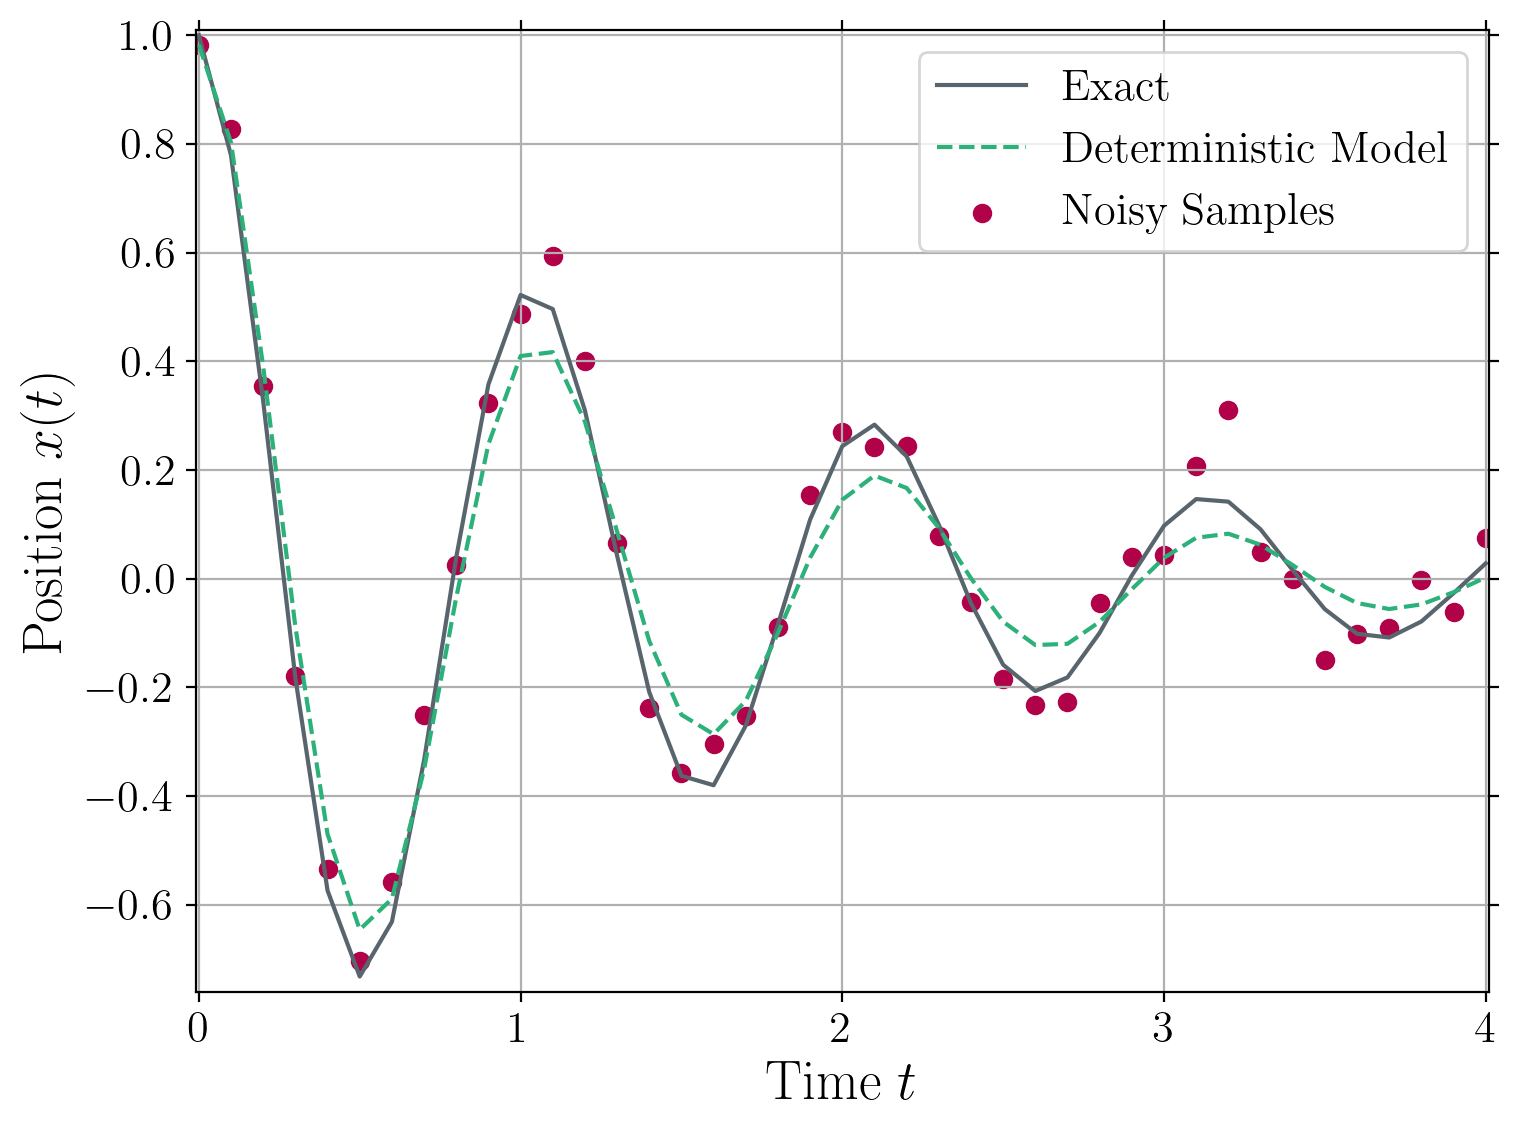

In [8]:
fig, ax =plt.subplots()

plt.frameon = True 
plt.grid(visible=True)

plt.plot(t, x_true, label='Exact', linewidth=1.5, color='xkcd:slate gray')
plt.plot(t, x_deter, color='xkcd:bluey green', linestyle='dashed', linewidth=1.5, label='Deterministic Model')
plt.scatter(t, obs, color='xkcd:raspberry', label='Noisy Samples')

plt.xlabel(r"Time $t$", fontsize=20, color = 'k')
plt.ylabel(r"Position $x(t)$", fontsize=20, color='k')

plt.tick_params(axis='x', which='both', top='off', color = 'k')
plt.xticks(fontsize=16, rotation=0, color = 'k')
plt.tick_params(axis='y', which='both', right='off', color = 'k')
plt.yticks(fontsize=16, rotation=0, color = 'k')
ax.locator_params(axis='y', nbins=12)
ax.locator_params(axis='x', nbins=8)

plt.legend(loc='upper right', fontsize=16)

plt.xlim([-0.01, 4.01])
plt.ylim([-0.76, 1.01])

plt.tight_layout()

fig.set_size_inches(8, 6)  

plt.show()

As mentioned earlier, the quality of the deterministic model could be improved by shrinking $\delta t$ or, equivalently, increasing $s$. However, I am artificially choosing a mediocre value of $\delta t$ to give rise to a mediocre numerical method, which in turn gives rise to a mediocre difference equation model of the dynamics. Why do this? In practice, one may have no choice but to use a mediocre model due to unknown or complicated physics, or because of computational limitations. I want to convince you that the Kalman filter can do a lot to correct sub-par models, which you will likely encounter in your career.  

## The Kalman Filter: Fusing Data and Model Predictions

Now that we have both our data and our purely deterministic prediction, we are ready to apply Kalman filtering. I leave a complete discussion of the beautiful theory behind the Kalman filter to the references.

Let's start by recalling that our system is affected by a noise term $[0,w]^{\mathrm{T}}$ with $w\sim \mathcal{N}\left(0,\sigma^2\right)$ for all $t$. That is, the covariance matrix of the noise term is 

$$
\widetilde{Q} = \begin{bmatrix} 0 & 0 \\ 0 & \sigma^2\end{bmatrix}. 
$$

To adapt to the discrete-time setting, the noise term must become 

$$
\mathbf{w}_{n} \sim \mathcal{N}\left(0, Q\right) \quad \forall \ n =1,...,N
$$

with covariance matrix $Q$ given by 

$$
Q = \begin{bmatrix} 0 & 0 \\ 0 & \sigma^2 \ \Delta t\end{bmatrix}. 
$$

To understand why, see for instance Higham 2001 (https://epubs.siam.org/doi/pdf/10.1137/S0036144500378302) or any other computational introduction to stochastic calculus. 

We have also chosen to obtain our measurements using a random variable distributed according to $\mathcal{N}\left(0,\sigma^2\right)$. Since we don't have to worry about accounting for $\Delta t$ for the measurement errors, the variance of the discrete-time measurements is still 

$$
R = \sigma^2.
$$

Let's put this objects into the code before going further: 

In [54]:
# observability matrix
H = np.array([1.,0.])

# covariance matrix of noise... if u want to add noise make sure to have a dt
Q = (scale*2)*dt*np.array([[0.,0.],[0., 1.]])

# covariance matrix of measurements = simply the variance in our case
R = scale**2 

Next, we need an initual guess at the covariance matrix of our state estimator. For clarity, let's call our filtered estimate at step $n$ by $\mathbf{x}^{\mathrm{filter}}_{n}$ (called $\mathbf{x}_{t|t}$ in Pei et al.). The $2\times 2$ covariance matrix of $\mathbf{x}^{\mathrm{filter}}_{n}$ is denoted $\Sigma_{n}$. 

The Kalman filtering algorithm requires the user to input a reasonable guess of $\Sigma_{0}$. For teaching purposes, and because of my own ignorance, I'll assume $\Sigma_0$ is quite large, allowing $\mathbf{x}(t)$ to fluctuate around $20\%$ or more from its mean. After enough time steps have elapsed, we'll find that the Kalman filter gives an estimator with a much smaller variance. 

In [55]:
sigma0 = 0.2*np.array([[1.,0.],[0.,2.]]) # TODO: good heuristic or rigorous rule for selecting this? 

Now we're ready to actually implement the Kalman filter for this problem. This is accomplished with an easy "for" loop and a few cheap matrix multiplications: the cost here is $\mathcal{O}\left(N\right)$ where $N$ is the number of times sampled. 

In [56]:
# initialize
sigma_t = np.copy(sigma0)

state_t = ic_noisy

In [57]:
# create data storage
state_data = np.zeros((2,N+1), dtype = float)
state_data[:, 0] = ic_noisy.T
sigma_data = np.zeros((2,2,N+1), dtype = float)
sigma_data[:, :, 0] = sigma0

for n in np.arange(1,N+1):   
    
    # obtain prior guess of state and variance
    state_prior = A @ state_t 

    sigma_prior = A @ sigma_t @ A.T + Q   

    # compute Kalman gain K
    S = sigma_prior @ np.reshape(H, (2,1))

    to_inv = H @ S + R
    
    K = S/to_inv

    # use prior + gain to get posterior
    state_posterior = state_prior + K * (obs[n]- H @ state_prior)

    sigma_posterior  = (np.eye(2)- np.outer(K,H)) @ sigma_prior

    # store
    state_data[:, n] = np.reshape(state_posterior,(2,))

    sigma_data[:,:, n] = sigma_posterior

    # update 
    state_t  = state_posterior

    sigma_t = sigma_posterior

Let's see how well the mean filtered signal $\widehat{x}^{\mathrm{filter}}_{n}$ captures the ground truth. 

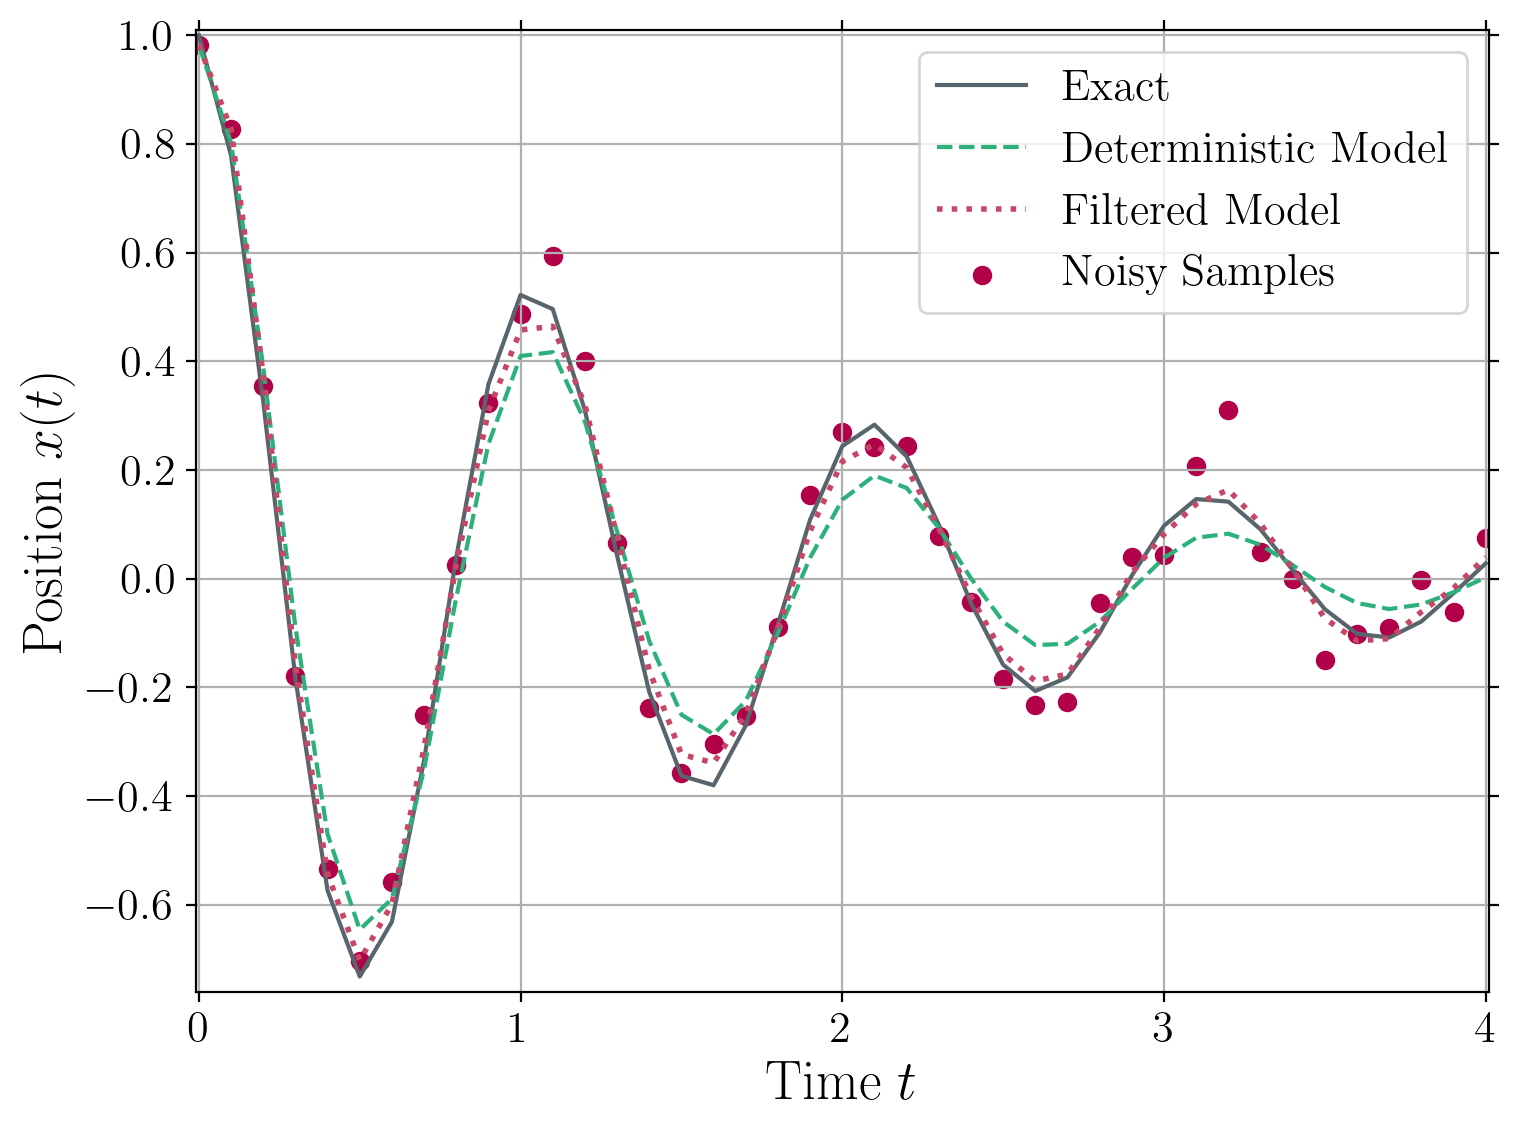

In [58]:
x_filter =  state_data[0,:]

fig, ax =plt.subplots()

plt.frameon = True 
plt.grid(visible=True)

plt.plot(t, x_true, label='Exact', linewidth=1.5, color='xkcd:slate gray')
plt.plot(t, x_deter, color='xkcd:bluey green', linestyle='dashed', linewidth=1.5, label='Deterministic Model')
plt.plot(t, x_filter, color='xkcd:deep rose', linestyle='dotted', linewidth=2, label='Filtered Model')
plt.scatter(t, obs, color='xkcd:raspberry', label='Noisy Samples')

plt.xlabel(r"Time $t$", fontsize=20, color = 'k')
plt.ylabel(r"Position $x(t)$", fontsize=20, color='k')

plt.tick_params(axis='x', which='both', top='off', color = 'k')
plt.xticks(fontsize=16, rotation=0, color = 'k')
plt.tick_params(axis='y', which='both', right='off', color = 'k')
plt.yticks(fontsize=16, rotation=0, color = 'k')
ax.locator_params(axis='y', nbins=12)
ax.locator_params(axis='x', nbins=8)

plt.legend(loc='upper right', fontsize=16)

plt.xlim([-0.01, 4.01])
plt.ylim([-0.76, 1.01])

plt.tight_layout()

fig.set_size_inches(8, 6)  

plt.show()

At a glance, the filtered model does a much better job of correctly capturing the damping rate. So, Kalman has really done his job well!

To put some numbers to this phenomenon, let's compute the errors associated to the deterministic and Kalman-filtered estimates: 

In [59]:
filter_error = np.linalg.norm(x_filter-x_true)
deter_error = np.linalg.norm(x_deter-x_true)
print('L2 Error in Kalman-filtered prediction = %.2f' % filter_error)
print('L2 Error in deterministic, data-agnostic predictions = %.2f' % deter_error)
percent_improvement = -100*(filter_error-deter_error)/(deter_error)
print('Percent improvement when Kalman is used = %.1f' % percent_improvement, '%')

L2 Error in Kalman-filtered prediction = 0.17
L2 Error in deterministic, data-agnostic predictions = 0.42
Percent improvement when Kalman is used = 59.1 %


 So, filtering more than halves the error! The data really can save a mediocre model. 

Finally, let's look at how the covariance matrix $\Sigma_{n}$ (called $\Sigma_{t|t}$ in Pei et al.) evolves with time. For simplicity, we just plot the trace of this matrix, as an indicator in how much uncertainty the algorithm thinks is in the filtered prediction. Recall from Pei et al. that the trace of $\Sigma_{n}$ is the mean-squared error of our state estimator. 

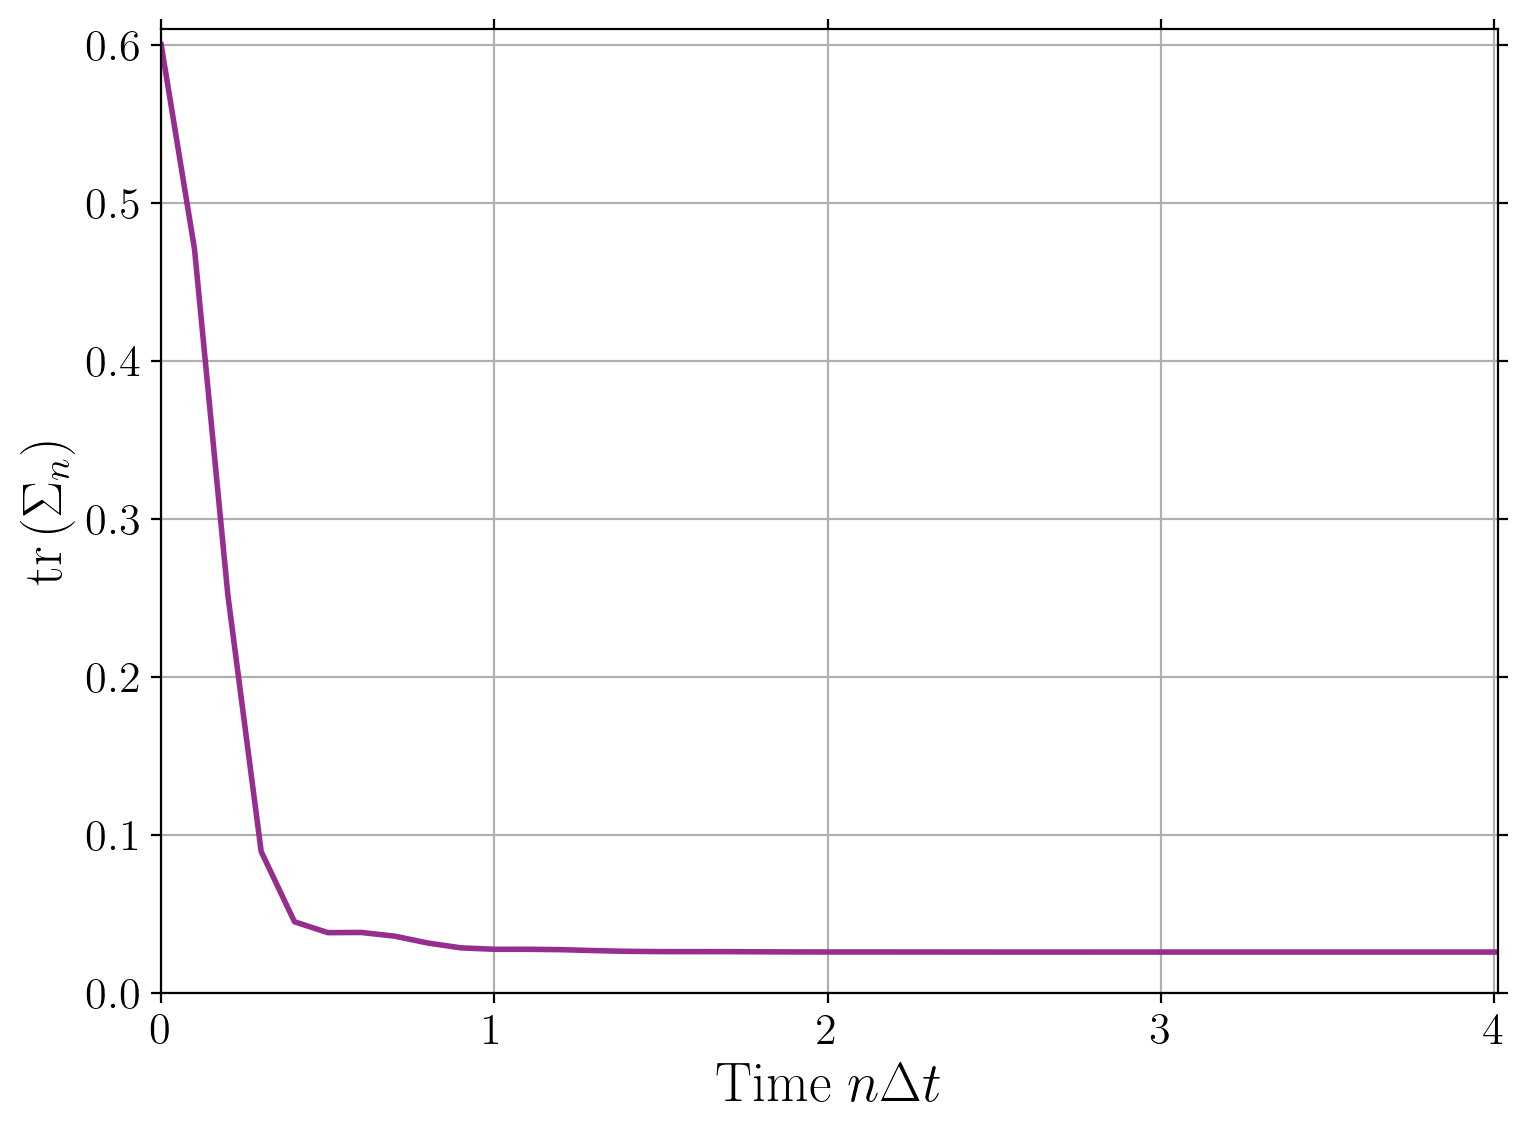

In [70]:
fig, ax =plt.subplots()

plt.frameon = True 
plt.grid(visible=True)

#plt.plot(t, np.linalg.norm(sigma_data[...,:], axis=(0,1)), color='xkcd:warm purple', linewidth=2)

plt.plot(t, np.trace(sigma_data[...,:]), color='xkcd:warm purple', linewidth=2)

plt.xlabel(r"Time $n\Delta t$", fontsize=20, color = 'k')
plt.ylabel(r"$\mathrm{tr}\left(\Sigma_{n}\right)$", fontsize=20, color='k')

plt.tick_params(axis='x', which='both', top='off', color = 'k')
plt.xticks(fontsize=16, rotation=0, color = 'k')
plt.tick_params(axis='y', which='both', right='off', color = 'k')
plt.yticks(fontsize=16, rotation=0, color = 'k')
ax.locator_params(axis='y', nbins=8)
ax.locator_params(axis='x', nbins=8)

plt.xlim([0.0, 4.01])
plt.ylim([0.0, 0.61])

plt.tight_layout()

fig.set_size_inches(8, 6)  

plt.show()

As theory leads us to expect, the trace gets very small very fast! 

I encourage you to mess around with the parameters (especially $\delta t = \texttt{Dt}$ and $\sigma = \texttt{scale}$) to see how the Kalman filter's performance is affected. 

In [66]:
# TODO: I don't really know about PyKalman's efficacy... it really looks like it just wants to overfit (try it with very clean and 
# very dirty data). This may be fixable by diving into the documentation, adjusting parameters, etc. but right now the 
# examples seem a bit sparse + support may not be great, so perhaps it is not worth it. 